In [49]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()




In [50]:
# Years
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)

df_ind_year = df_ind[["individual_wikidata_id", "birthyear", "individual_name"]].drop_duplicates()
df_ind_year = df_ind_year[~df_ind_year['birthyear'].isna()]
df_ind_year["productive_year"] = df_ind_year["birthyear"] + 35
temporal_resolution = 10
df_ind_year["decade"] = df_ind_year["productive_year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)
df_ind_year = df_ind_year[df_ind_year['decade']<=1850]


# Individuals Regions
df_ind_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_ind_regions = df_ind_regions[['individual_wikidata_id', 'region_name']].drop_duplicates()


In [51]:
df_catalogs_id = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)

In [52]:
df_catalogs_counts = df_catalogs_id.groupby('individual_wikidata_id')['identifiers_wikidata_id'].count().reset_index()
df_catalogs_counts = df_catalogs_counts.sort_values('identifiers_wikidata_id', ascending=False)

In [65]:
df_final = pd.merge(df_ind_year, df_catalogs_counts, on = 'individual_wikidata_id')

region_name =  'Low countries'

min_date = 1000
max_date = 1850

df_reg_fil = df_ind_regions[df_ind_regions['region_name']==region_name]

df_final = pd.merge(df_final, df_reg_fil, on = 'individual_wikidata_id')
df_final = df_final[df_final['decade']>=min_date]
df_final = df_final[df_final['decade']<=max_date]

In [66]:
df_ids = df_final[['individual_wikidata_id', 'identifiers_wikidata_id']].sort_values('identifiers_wikidata_id', ascending=False)
num = int(round(len(top_ids)*0.2, 0))
top_20 = df_ids.head(num)

num = int(round(len(top_ids)*0.2, 0))
bottom_20 = df_ids.tail(num)

sample_20 = df_ids.sample(num, random_state=42)

In [67]:
df_top_20 = df_final[df_final['individual_wikidata_id'].isin(list(top_20.individual_wikidata_id))]
df_top_20['type'] = 'top_20%'
df_bottom_20 = df_final[df_final['individual_wikidata_id'].isin(list(bottom_20.individual_wikidata_id))]
df_bottom_20['type'] = 'bottom_20%'
df_sample_20 = df_final[df_final['individual_wikidata_id'].isin(list(sample_20.individual_wikidata_id))]
df_sample_20['type'] = 'sample_20%'

df_concat = pd.concat([df_top_20, df_bottom_20, df_sample_20])
df_concat = df_concat.reset_index(drop=True)
df_concat

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_26769/3495442792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_20['type'] = 'top_20%'
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_26769/3495442792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bottom_20['type'] = 'bottom_20%'
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_26769/3495442792.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,individual_wikidata_id,birthyear,individual_name,productive_year,decade,identifiers_wikidata_id,region_name,type
0,Q314275,1466.0,Quinten Metsys,1501.0,1500,99,Low countries,top_20%
1,Q315000,1337.0,Jean Froissart,1372.0,1370,88,Low countries,top_20%
2,Q468214,1631.0,Ludolf Bakhuizen,1666.0,1670,75,Low countries,top_20%
3,Q153472,1485.0,Joos van Cleve,1520.0,1520,78,Low countries,top_20%
4,Q209050,1568.0,Jan Brueghel the Elder,1603.0,1600,125,Low countries,top_20%
...,...,...,...,...,...,...,...,...
517,Q1930132,1604.0,Michaelina Wautier,1639.0,1640,27,Low countries,sample_20%
518,Q105945833,1803.0,Johannes Jacobus Kerrebijn,1838.0,1840,5,Low countries,sample_20%
519,Q606757,1573.0,Antonius Walaeus,1608.0,1610,31,Low countries,sample_20%
520,Q1521375,1610.0,Isabel Henríquez,1645.0,1640,5,Low countries,sample_20%


In [68]:
df_fig = df_concat.groupby(['type', 'decade'])['individual_wikidata_id'].count().reset_index()
df_fig

,type,decade,individual_wikidata_id
0,bottom_20%,1380,1
1,bottom_20%,1390,1
2,bottom_20%,1420,1
3,bottom_20%,1440,1
4,bottom_20%,1460,1
...,...,...,...
110,top_20%,1760,1
111,top_20%,1780,1
112,top_20%,1820,1
113,top_20%,1830,1


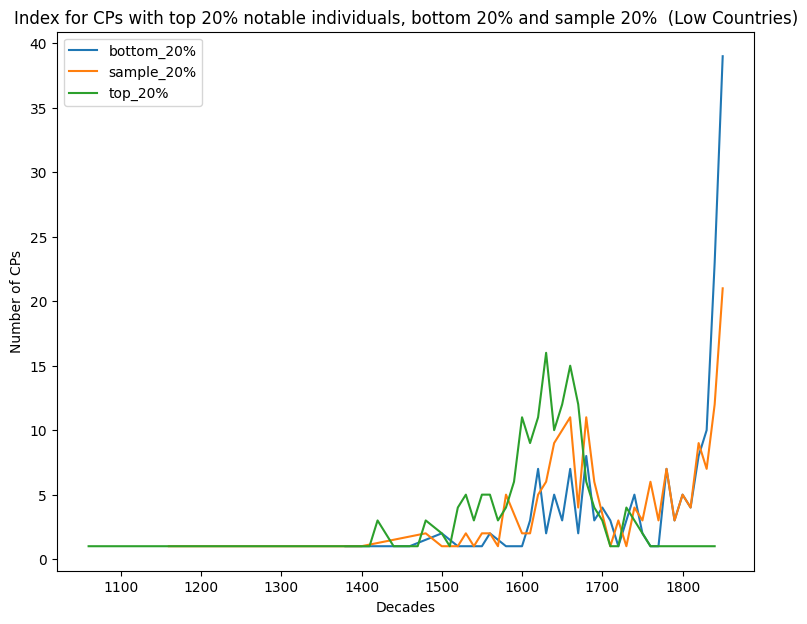

In [71]:
import matplotlib.pyplot as plt


# Plot a line for each creation year category
plt.figure(figsize=(9, 7))

for var, group in df_fig.groupby('type'):
    plt.plot(group['decade'], group['individual_wikidata_id'], label=var)

plt.title('Index for CPs with top 20% notable individuals, bottom 20% and sample 20%  (Low Countries)')
plt.xlabel('Decades')
plt.ylabel('Number of CPs')
plt.legend()
plt.grid(False)

plt.savefig('figures/wikidata_stats/evolution_with_notable_individuals.png', dpi = 200)
plt.show()

In [72]:
df_corr = df_fig.pivot(index = "decade", columns = "type", values = 'individual_wikidata_id')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.5672480013398268